In [1]:
import os

In [2]:
os.chdir('../')
%pwd

'/home/ec2-user/Face-Classification-Project/Facial_Impression_Recognition_Calassification'

In [3]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    trained_model_path: Path
    trained_model_json_path: Path
    updated_model_path: Path
    updated_model_json_path: Path
    training_data: Path
    validation_data: Path
    params_epochs: int
    params_batch_size: int
    params_is_augmentation: bool
    params_imgage_size: list
    learning_rate: float

@dataclass(frozen=True)
class PrepareCallbacksConfig:
    root_dir: Path
    tensorboard_root_log_dir: Path
    ckeckpoint_model_filepath: Path
    patience: int

In [4]:
from cnnClassifier.constants import *
from cnnClassifier.utils import read_yaml, create_directories

2023-08-03 20:54:30.594736: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-03 20:54:32.874705: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
class configurationManeger:
    def __init__(self, 
                 config_filepath = CONFIG_FILE_PATH,
                 secret_filepath = SECRET_FILE_PATH,                 
                 params_filepath = PARAMS_FILE_PATH):
        
        self.config = read_yaml(config_filepath) 
        self.secret = read_yaml(secret_filepath)        
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])   
    
    def get_prepare_callbacks_config(self) -> PrepareCallbacksConfig:
        config = self.config.prepare_callbacks
        model_ckpt_dir = os.path.dirname(config.ckeckpoint_model_filepath)

        create_directories([config.tensorboard_root_log_dir, model_ckpt_dir ])

        prepare_callbacks_config = PrepareCallbacksConfig(
           root_dir= config.root_dir,
           tensorboard_root_log_dir= config.tensorboard_root_log_dir,
           ckeckpoint_model_filepath=  config.ckeckpoint_model_filepath,
           patience = self.params.PATIENCE

        )

        return prepare_callbacks_config 
    
    def get_training_config(self) -> TrainingConfig:
        config= self.config.training
        training_data_dir = os.path.dirname(self.config.data_transformation.local_train_angry_dir)
        validation_data_dir = os.path.dirname(self.config.data_transformation.local_val_angry_dir)
        
        create_directories([config.root_dir])

        training_config = TrainingConfig(
        root_dir= config.root_dir,
        trained_model_path= config.trained_model_path, 
        trained_model_json_path = config.trained_model_json_path,
        updated_model_path= self.config.prepare_base_model.updated_model_path, 
        updated_model_json_path = self.config.prepare_base_model.updated_model_json_path,
        training_data= training_data_dir,
        validation_data= validation_data_dir, 
        params_epochs= self.params.EPOCHS, 
        params_batch_size= self.params.BATCH_SIZE, 
        params_is_augmentation= self.params.AUGMENTATION,
        params_imgage_size= self.params.IMAGE_SIZE,
        learning_rate= self.params.LEARNING_RATE
        )

        return training_config

In [6]:
from cnnClassifier.utils import save_model, model_loss, confusion_matrix_display, pandas_classification_report, load_model
import keras

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

class Training:
    def __init__(self, config: TrainingConfig):
        self.config = config

    def get_base_model(self):
        self.model = load_model(h5_path= self.config.updated_model_path , json_path = self.config.updated_model_json_path)
        self.model.compile(optimizer=keras.optimizers.Adam(learning_rate=self.config.learning_rate),
            loss = keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy']
                           )   

    def train_valid_generator(self):

        datagenerator_kwargs = dict(
            # Dividing the pixels by 255 for normalization  => range(0,1)
            # Scaling the pixels value in range(-1,1) by subtracting 0.5 and multiply 2
            rescale= ((1./255) - 0.5)*2,            
            # if there was no validation set:
            # validation_split = 0.20
        )

        dataflow_kwargs = dict(
            target_size=self.config.params_imgage_size[:-1],            
            batch_size = self.config.params_batch_size,
            interpolation= 'bilinear',
            color_mode="grayscale"

        )
        ## NOTE: Keras generator alway looks for subfolders (representing the classes). Images insight the subfolders are associated with a class.
        if self.config.params_is_augmentation:
            datagenerator = keras.preprocessing.image.ImageDataGenerator(
                featurewise_center=False,
                featurewise_std_normalization=False,
                rotation_range=10,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=.1,
                horizontal_flip=True,
                **datagenerator_kwargs
            )

        else:
            datagenerator = keras.preprocessing.image.ImageDataGenerator(
                **datagenerator_kwargs
            )
        ## NOTE: subset is added when we use validation_split, where directory for both training and validation is the same.
        ## NOTE: shuffle= False for validation as we want to check the performance model using predict_generator 
        self.valid_generator = datagenerator.flow_from_directory(
            directory= self.config.validation_data,
            #subset= "validation",
            shuffle= False,            
            **dataflow_kwargs
            )
        
        self.train_generator = datagenerator.flow_from_directory(
            directory= self.config.training_data,
            #subset= "training",
            shuffle= True,           
            **dataflow_kwargs
            )
        
    def train(self, callback_list: list):
        self.steps_per_epoch = self.train_generator.samples // self.train_generator.batch_size
        self.validation_steps = self.valid_generator.samples // self.valid_generator.batch_size

        history = self.model.fit(
            self.train_generator,
            validation_data = self.valid_generator,
            epochs= self.config.params_epochs,
            steps_per_epoch= self.steps_per_epoch,
            validation_steps=self.validation_steps,
            callbacks = callback_list
            )
        
        model_loss(history)
        filenames = self.valid_generator.filenames
        nb_samples = len(filenames)
        predict = self.model.predict_generator(self.valid_generator, steps = nb_samples)
        predict_classes = predict.argmax(axis=1)
        labels = ["angry", "disgust", "fear", 'happy', 'neutral', 'sad', 'surprise']
        report = pandas_classification_report(self.valid_generator.classes, predict_classes, labels)
        print(report)
        confusion_matrix_display(self.valid_generator.classes, predict_classes, labels)
        

        save_model(h5_path= self.config.trained_model_path, json_path=self.config.trained_model_json_path, model=self.model)  

In [8]:
import sys
from cnnClassifier.exception import CustomException
from cnnClassifier.components.prepare_callbacks import PrepareCallbacks 

Found 3589 images belonging to 7 classes.
Found 28709 images belonging to 7 classes.
Epoch 1/150


2023-08-03 20:55:11.289637: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


897/897 [==============================] - ETA: 0s - loss: 1.8203 - accuracy: 0.2880

/home/ec2-user/Face-Classification-Project/Facial_Impression_Recognition_Calassification/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


897/897 [==============================] - 59s 60ms/step - loss: 1.8203 - accuracy: 0.2880 - val_loss: 1.5886 - val_accuracy: 0.3887
Epoch 2/150
897/897 [==============================] - 25s 28ms/step - loss: 1.5197 - accuracy: 0.4122 - val_loss: 1.5866 - val_accuracy: 0.3982
Epoch 3/150
897/897 [==============================] - 25s 28ms/step - loss: 1.3962 - accuracy: 0.4645 - val_loss: 1.3125 - val_accuracy: 0.4967
Epoch 4/150
897/897 [==============================] - 25s 28ms/step - loss: 1.3355 - accuracy: 0.4875 - val_loss: 1.2570 - val_accuracy: 0.5215
Epoch 5/150
897/897 [==============================] - 25s 28ms/step - loss: 1.2870 - accuracy: 0.5083 - val_loss: 1.3096 - val_accuracy: 0.5020
Epoch 6/150
897/897 [==============================] - 27s 30ms/step - loss: 1.2556 - accuracy: 0.5231 - val_loss: 1.2418 - val_accuracy: 0.5117
Epoch 7/150
897/897 [==============================] - 25s 28ms/step - loss: 1.2300 - accuracy: 0.5349 - val_loss: 1.1771 - val_accuracy: 0.54

/home/ec2-user/Face-Classification-Project/Facial_Impression_Recognition_Calassification/src/cnnClassifier/utils.py:206: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


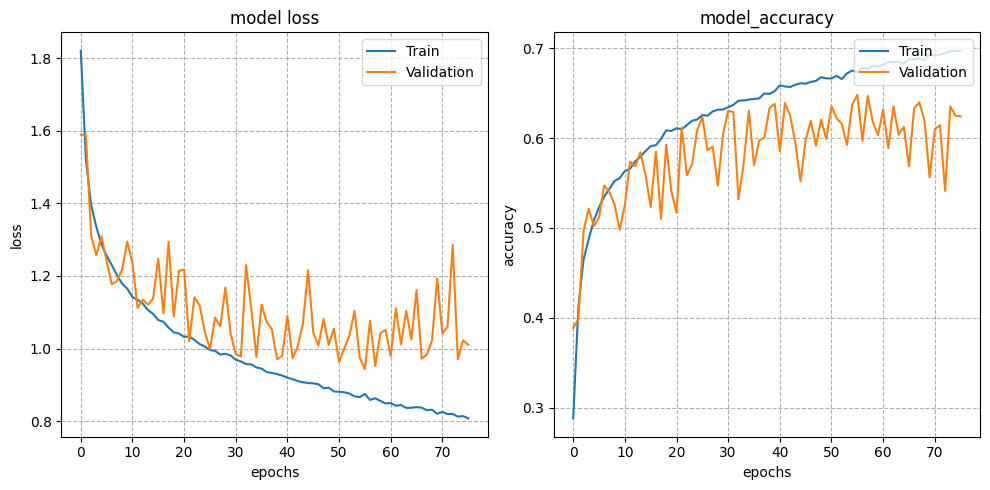

/tmp/ipykernel_7603/1622460830.py:81: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = self.model.predict_generator(self.valid_generator, steps = nb_samples)


             precision    recall  f1-score  support
angry         0.602771  0.558887  0.580000    467.0
disgust       0.806452  0.446429  0.574713     56.0
fear          0.630137  0.278226  0.386014    496.0
happy         0.895275  0.783240  0.835518    895.0
neutral       0.512987  0.650741  0.573711    607.0
sad           0.472316  0.640123  0.543563    653.0
surprise      0.726496  0.819277  0.770102    415.0
avg / total   0.658060  0.634717  0.631117   3589.0


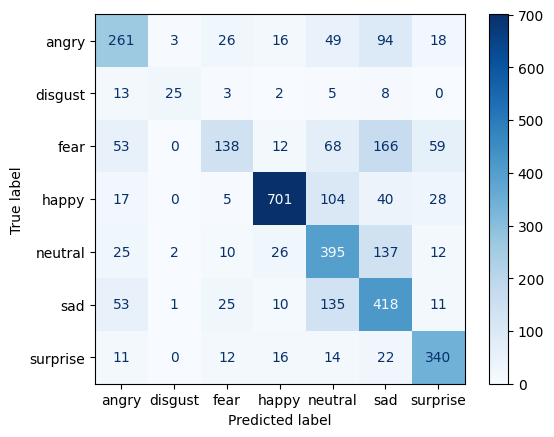

In [10]:
try:
    config = configurationManeger()
    prepare_callbacks_config = config.get_prepare_callbacks_config()
    prepare_callbacks = PrepareCallbacks(config=prepare_callbacks_config)
    callback_list = prepare_callbacks.get_tb_ckpt_es_callbacks()

    training_config = config.get_training_config()
    training = Training(config= training_config)
    training.get_base_model()
    training.train_valid_generator()
    training.train(callback_list= callback_list)

except Exception as e:
    raise CustomException(e, sys)